# NicheCompass Multimodal Tutorial

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 18.05.2023
- **Date of Last Modification:** 18.05.2023

This is work in progress.

## 1. Setup

### 1.1 Import Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import squidpy as sq
from matplotlib import gridspec

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                add_multimodal_mask_to_adata,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_ligand_target_mx,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                get_gene_annotations,
                                generate_multimodal_pairing_dict,
                                get_unique_genes_from_gp_dict)

### 1.2 Define Parameters

In [94]:
### Dataset ###
spatial_key = "spatial"
n_neighbors = 8
filter_genes = True
n_hvg = 3000
filter_peaks = True
min_cell_peak_thresh_ratio = 0.0005 # 0.05%

### Model ###
# AnnData keys
counts_key = "counts"
adj_key = "spatial_connectivities"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_sources_mask_key = "nichecompass_gp_sources"
latent_key = "nichecompass_latent"

# Architecture
active_gp_thresh_ratio = 0.05
node_label_method = "one-hop-norm" # choose one-hop-attention for more performant model training
log_variational = counts_key == "counts" # True if raw counts, False if log normalized counts

# Trainer
n_epochs = 100
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_chrom_access_recon = 150.
lambda_l1_masked = 10.
edge_batch_size = 4096
use_cuda_if_available = True

### Analysis ###
rna_cluster_key = "RNA_clusters"
atac_cluster_key = "ATAC_clusters"
latent_leiden_resolution = 0.6
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
random_seed = 0
agg_weights_key = "agg_weights"

In [ ]:
node_label_method = "one-hop-attention"
n_hvg = 300
min_cell_peak_thresh_ratio=0.1

### 1.3 Run Notebook Setup

In [ ]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Create Directories

In [ ]:
# Define paths
ga_data_folder_path = "../data/gene_annotations"
gp_data_folder_path = "../data/gene_programs"
so_data_folder_path = "../data/spatial_omics"
omnipath_ligand_receptor_interactions_file_path = f"{gp_data_folder_path}/omnipath_lr_interactions.csv"
nichenet_ligand_target_interactions_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gtf_file_path = f"{ga_data_folder_path}/gencode.vM32.chr_patch_hapl_scaff.annotation.gtf.gz"
artifacts_folder_path = f"../artifacts"
figure_folder_path = f"{artifacts_folder_path}/multimodal/figures"
model_folder_path = f"{artifacts_folder_path}/multimodal/models"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(model_folder_path, exist_ok=True)

## 2. Model Preparation

### 2.1 Create Prior Knowledge Cell-Cell-Interaction Gene Program (GP) Mask

The user can provide a custom GP mask to NicheCompass based on the dataset, application, and hypothesis of interest. 

As a default, we create a GP mask based on three databases of prior cell-cell-interaction knowledge:
- OmniPath
- NicheNet
- MEBOCOST

In [ ]:
# Retrieve OmniPath GPs (source: ligand gene; target: receptor gene)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=True,
    save_to_disk=False,
    file_path=omnipath_ligand_receptor_interactions_file_path,
    plot_gp_gene_count_distributions=True)

# Retrieve unique source and target genes from OmniPath GPs to keep
# those genes when filtering
omnipath_genes = get_unique_genes_from_gp_dict(
    gp_dict=omnipath_gp_dict,
    retrieved_gene_entities=["sources", "targets"])

In [ ]:
# Retrieve NicheNet GPs (source: ligand gene; target: target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_genes_ratio=0.01,
    max_n_target_genes_per_gp=1000,
    load_from_disk=True,
    save_to_disk=False,
    file_path=nichenet_ligand_target_interactions_file_path,
    plot_gp_gene_count_distributions=True)

# Retrieve unique source genes from NicheNet GPs to keep
# those genes when filtering
nichenet_source_genes = get_unique_genes_from_gp_dict(
    gp_dict=nichenet_gp_dict,
    retrieved_gene_entities=["sources"])

In [ ]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species="mouse",
    plot_gp_gene_count_distributions=True)

# Retrieve unique source and target genes from MEBOCOST GPs to keep
# those genes when filtering
mebocost_genes = get_unique_genes_from_gp_dict(
    gp_dict=mebocost_gp_dict,
    retrieved_gene_entities=["sources", "targets"])

In [ ]:
# Add GPs into one dictionary
combined_gp_dict = dict(omnipath_gp_dict)
combined_gp_dict.update(nichenet_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [ ]:
# Filter and combine GPs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

### 2.2 Load Data & Compute Spatial Neighbor Graph

- In the multimodal setting, we will provide one adata object per modality to NicheCompass.
- NicheCompass expects a precomputed spatial adjacency matrix stored in 'adata.obsp[adj_key]'.
- The user can customize the spatial neighbor graph construction based on the dataset and application of interest.

In [ ]:
# Read data
adata = sc.read_h5ad(
        f"{so_data_folder_path}/spatial_atac_rna_seq_mouse_brain.h5ad")
adata_atac = sc.read_h5ad(
        f"{so_data_folder_path}/spatial_atac_rna_seq_mouse_brain_atac.h5ad")

In [ ]:
# Compute (separate) spatial neighborhood graphs
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors)

# Make adjacency matrix symmetric
adata.obsp[adj_key] = (
    adata.obsp[adj_key].maximum(
        adata.obsp[adj_key].T))

### 2.3 Filter Genes & Peaks

In [ ]:
if filter_genes:
    print("Filtering genes...")
    # Filter genes and only keep ligand, receptor, metabolitye enzyme, 
    # metabolite sensor and the 'n_hvg' highly variable genes (potential target
    # genes of nichenet)
    gp_dict_genes = get_unique_genes_from_gp_dict(
        gp_dict=combined_new_gp_dict,
            retrieved_gene_entities=["sources", "targets"])
    print(f"Starting with {len(adata.var_names)} genes.")
    sc.pp.filter_genes(adata,
                       min_cells=0)
    print(f"Keeping {len(adata.var_names)} genes after filtering genes with "
          "expression in 0 cells.")

    if (adata.layers[counts_key].astype(int).astype(np.float32).sum() == 
    adata.layers[counts_key].sum()): # raw counts
        hvg_flavor = "seurat_v3"
    else: # log normalized counts
        hvg_flavor = "seurat"

    sc.pp.highly_variable_genes(
        adata,
        layer=counts_key,
        n_top_genes=n_hvg,
        flavor=hvg_flavor,
        subset=False)

    # Get gene program relevant genes
    gp_relevant_genes = list(set(omnipath_genes + 
                                 nichenet_source_genes + 
                                 mebocost_genes))
    
    adata.var["gp_relevant"] = (
        adata.var.index.str.upper().isin(gp_relevant_genes))
    adata.var["keep_gene"] = (adata.var["gp_relevant"] | 
                              adata.var["highly_variable"])
    adata = adata[:, adata.var["keep_gene"] == True]
    print(f"Keeping {len(adata.var_names)} highly variable or gene program "
          "relevant genes.")
    adata = (adata[:, adata.var_names[adata.var_names.str.upper().isin(
                gp_dict_genes)].sort_values()])
    print(f"Keeping {len(adata.var_names)} genes after filtering genes not in "
          "gp dict.")
    
if filter_peaks:
    print("\nFiltering peaks...")
    print(f"Starting with {len(adata_atac.var_names)} peaks.")
    # Filter out peaks that are rarely detected to reduce GPU footprint of model
    min_cells = int(adata_atac.shape[0] * min_cell_peak_thresh_ratio)
    sc.pp.filter_genes(adata_atac, min_cells=min_cells)
    print(f"Keeping {len(adata_atac.var_names)} peaks after filtering peaks with "
          f"counts in less than {int(adata_atac.shape[0] * min_cell_peak_thresh_ratio)} cells.")

### 2.4 Annotate Genes

In [ ]:
adata, adata_atac = get_gene_annotations(
    adata=adata,
    adata_atac=adata_atac,
    gtf_file_path=gtf_file_path)

### 2.5 Add GP Mask to Data

In [ ]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

### 2.6 Add Chromatin Accessibility Mask to Data

In [ ]:
gene_peak_dict = generate_multimodal_pairing_dict(
    adata,
    adata_atac)

In [ ]:
adata, adata_atac = add_multimodal_mask_to_adata(
    adata=adata,
    adata_atac=adata_atac,
    gene_peak_mapping_dict=gene_peak_dict)

print(f"Keeping {len(adata_atac.var_names)} peaks after filtering peaks with "
      "no matching genes in gp mask.")

### 2.7 Explore Data

In [ ]:
print(f"Number of nodes (observations): {adata.layers['counts'].shape[0]}")
print(f"Number of gene node features: {adata.layers['counts'].shape[1]}")
print(f"Number of peak node features: {adata_atac.layers['counts'].shape[1]}")

# Visualize spot-level annotated data in physical space
sc.pl.spatial(adata,
              color=rna_cluster_key,
              spot_size=20)
sc.pl.spatial(adata_atac,
              color=atac_cluster_key,
              spot_size=20) 

## 3. Model Training

### 3.1 Initialize, Train & Save Model

In [ ]:
# Initialize model
model = NicheCompass(adata,
                     adata_atac,
                     counts_key=counts_key,
                     adj_key=adj_key,
                     gp_names_key=gp_names_key,
                     active_gp_names_key=active_gp_names_key,
                     gp_targets_mask_key=gp_targets_mask_key,
                     gp_sources_mask_key=gp_sources_mask_key,
                     latent_key=latent_key,
                     active_gp_thresh_ratio=active_gp_thresh_ratio,
                     log_variational=log_variational,
                     node_label_method=node_label_method)

In [ ]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_chrom_access_recon=lambda_chrom_access_recon,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size,
            use_cuda_if_available=use_cuda_if_available,
            verbose=True)

In [ ]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)


# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [ ]:
# Save trained model
model.save(dir_path=f"{model_folder_path}/{current_timestamp}",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad",
           save_adata_atac=True,
           adata_atac_file_name=f"adata_atac.h5ad")

## 4. Analysis

In [77]:
# Load trained model
load_timestamp = "02062023_151955"
model = NicheCompass.load(dir_path=f"{model_folder_path}/{load_timestamp}",
                          adata=None,
                          adata_file_name="adata.h5ad",
                          adata_atac=None,
                          adata_atac_file_name="adata_atac.h5ad",
                          gp_names_key=gp_names_key)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb, include_chrom_access_recon_loss: True, chrom_access_recon_dist: nb 
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.05
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['gene_expr_decoder', 'chrom_access_decoder']
ENCODER -> n_input: 20755, n_cond_embed_input: 0, n_layers: 1, n_hidden: 1486, n_latent: 1486, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> n_cond_embed_input: 0, n_cond_embed_output: 1486, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 1486, n_cond_embed_input: 1486, n_addon_input: 0, n_output: 7354
MASKED CHROMATIN ACCESSIBILITY DECODER -> n_input: 1486, n_cond_embed_input: 1486, n_addon_input: 0, n_output: 34156
ONE HOP GCN NORM NODE LABEL AGGREGATOR


In [78]:
# Check number of active GPs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 1486.
Number of active gene programs: 991.


In [79]:
# Inspect GPs
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True].head()

/home/cartalop/sebastianbirk/nichecompass/nichecompass/models/nichecompass.py:1851: RuntimeWarning: invalid value encountered in divide
  chrom_access_gp_weights / np.abs(chrom_access_gp_weights).sum(0))


,gp_name,all_gp_idx,gp_active,active_gp_idx,n_source_genes,n_non_zero_source_genes,n_target_genes,n_non_zero_target_genes,gp_source_genes,gp_target_genes,...,n_source_peaks,n_non_zero_source_peaks,n_target_peaks,n_non_zero_target_peaks,gp_source_peaks,gp_target_peaks,gp_source_peaks_weights_sign_corrected,gp_target_peaks_weights_sign_corrected,gp_source_peaks_importances,gp_target_peaks_importances
1,EPOR_ligand_receptor_GP,1,True,0,1,1,1,1,[Epor],[Stat3],...,1,1,7,7,[chr9:21870692-21871597],"[chr11:100828511-100829420, chr11:100791369-10...",[0.0578],"[-0.0241, -0.0212, 0.0168, -0.0157, -0.0136, 0...",[0.3662],"[0.1529, 0.1341, 0.1062, 0.0996, 0.0861, 0.050..."
2,FYN_ligand_receptor_GP,2,True,1,1,1,1,1,[Fyn],[Mapk7],...,16,16,0,0,"[chr10:39387216-39387979, chr10:39440178-39441...",[],"[-0.1431, 0.053, 0.0513, 0.0442, -0.0361, 0.03...",[],"[0.2609, 0.0967, 0.0935, 0.0806, 0.0659, 0.064...",[]
3,NGF_ligand_receptor_GP,3,True,2,1,1,1,1,[Ngf],[Smpd2],...,0,0,0,0,[],[],[],[],[],[]
4,KL_ligand_receptor_GP,4,True,3,1,1,0,0,[Kl],[],...,1,1,0,0,[chr5:150905927-150906821],[],[0.1186],[],[1.0],[]
5,S100A10_ligand_receptor_GP,5,True,4,1,1,1,1,[S100a10],[Htr1b],...,0,0,0,0,[],[],[],[],[],[]


### 4.1 NicheCompass Latent Manifold Overview

In [80]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [82]:
groups = None
samples = ["p22"]
sample_key = "batch"
save_fig = False

/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


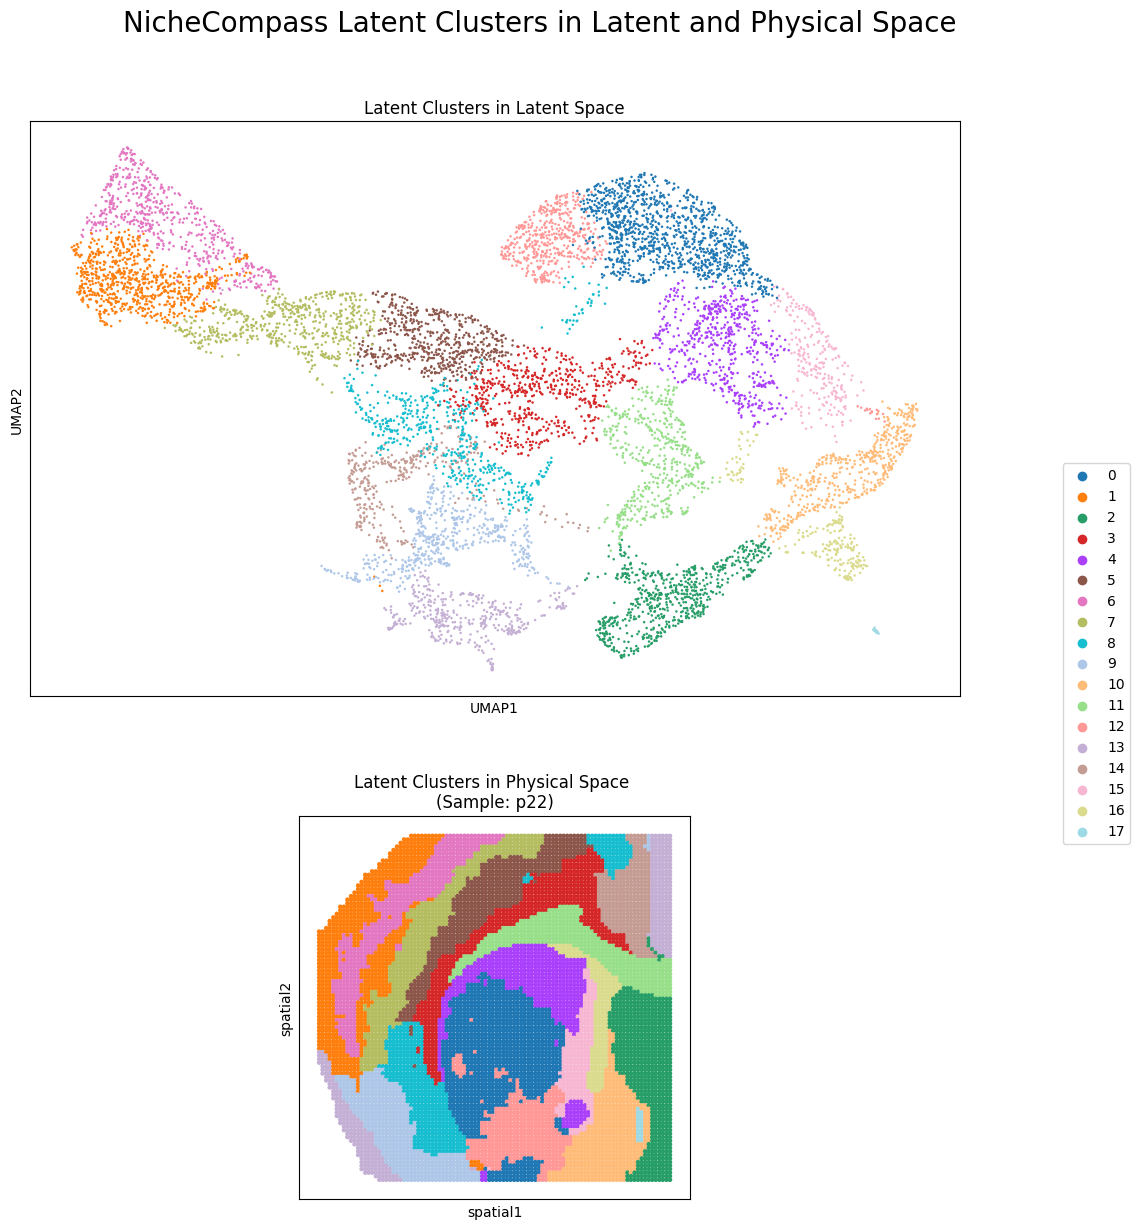

In [83]:
# Create plot of cell type annotations in physical and latent space
fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"NicheCompass Latent Clusters " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[latent_cluster_key],
           groups=groups,
           title=f"Latent Clusters in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[1 + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[latent_cluster_key],
                  groups=groups,
                  spot_size=30.,
                  title=f"Latent Clusters in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

### 4.1 Niche Cell-Cell-Interaction Analysis

Now we will investigate cell-cell-interaction patterns in different niches.

In [93]:
# Retrieve node neighbor importances 
# (aggregation weights of the node label aggregator)
model.adata.obsp[agg_weights_key] = model.get_neighbor_importances()

In [124]:
model.adata.obs

,RNA_clusters,ATAC_clusters,batch,mapping_entity,latent_leiden_0.6
CTAAGGTCTTGCTGGA,R10,C6,p22,reference,13
CTAAGGTCACACAGAA,R0,C2,p22,reference,1
CTAAGGTCACAGCAGA,R1,C6,p22,reference,1
CTAAGGTCACCTCCAA,R1,C2,p22,reference,1
CTAAGGTCACGCTCGA,R0,C5,p22,reference,1
...,...,...,...,...,...
GAACAGGCGATGAATC,R3,C5,p22,reference,13
GAACAGGCGCCAAGAC,R1,C5,p22,reference,13
GAACAGGCCGGAAGAA,R7,C5,p22,reference,13
GAACAGGCGTGACAAG,R3,C2,p22,reference,13


In [125]:
df = aggregate_obsp_matrix_per_cell_type(
    adata=model.adata,
    obsp_key=agg_weights_key,
    cell_type_key=rna_cluster_key,
    group_key=latent_cluster_key)

In [127]:
df

R0         R1       R10        R2  \
RNA_clusters latent_leiden_0.6                                              
R0           0                    0.444444   0.222222  0.000000  2.666667   
             1                  118.679372  77.803332  1.282602  1.627046   
             2                    3.071784   0.877778  0.111111  0.105409   
             3                  119.777787  33.777780  3.111111  2.111111   
             4                    0.444444   0.111111  0.000000  0.111111   
...                                    ...        ...       ...       ...   
R10          13                   0.000000   2.907343  0.766667  0.000000   
             14                   2.111111   0.222222  0.333333  0.000000   
             15                   0.000000   0.000000  0.111111  0.555556   
             16                   0.000000   0.000000  0.000000  0.000000   
             17                   0.000000   0.000000  0.000000  0.000000   

                                       R3         R4        R5         R6  \
RNA_clusters latent_leiden_0.6                                              
R0           0                   0.555556   0.111111  0.000000   0.000000   
             1                   3.331063   0.666667  0.000000  11.673637   
             2                  10.026169   2.099708  0.327631   1.088304   
             3                   4.333334  35.444447  5.666667  12.111112   
             4                   0.421637   0.555556  0.000000   0.333333   
...                                   ...        ...       ...        ...   
R10          13                  0.444444   0.000000  0.000000   0.444444   
             14                  0.000000   0.111111  0.000000   0.222222   
             15                  0.222222   0.111111  0.000000   0.000000   
             16                  0.000000   0.000000  0.000000   0.000000   
             17                  0.000000   0.000000  0.000000   0.000000   

                                      R7        R8   R9  
RNA_clusters latent_leiden_0.6                           
R0           0                  0.000000  0.000000  0.0  
             1                  3.429763  4.094006  0.0  
             2                  0.438743  0.872076  0.0  
             3                  0.000000  8.666667  0.0  
             4                  0.000000  0.000000  0.0  
...                                  ...       ...  ...  
R10          13                 2.360298  0.000000  0.0  
             14                 0.000000  0.000000  0.0  
             15                 0.000000  0.000000  0.0  
             16                 0.000000  0.000000  0.0  
             17                 0.000000  0.000000  0.0  

[198 rows x 11 columns]

In [106]:
model.adata.obsp[agg_weights_key].sum(0)

matrix([[0.98859635, 0.95853154, 0.95932794, ..., 0.97748523, 1.07690002,
         0.96067225]])